In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv
/kaggle/input/playground-series-s3e26/sample_submission.csv
/kaggle/input/playground-series-s3e26/train.csv
/kaggle/input/playground-series-s3e26/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, LabelEncoder
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

In [3]:
path = Path('/kaggle/input/playground-series-s3e26')
original_data = pd.read_csv('/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv')
sample_sub = pd.read_csv('/kaggle/input/playground-series-s3e26/sample_submission.csv')

In [4]:
train = pd.read_csv(str(path)+'/train.csv')
test = pd.read_csv(str(path)+'/test.csv')
train.head(2)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C


In [5]:
original_data.head(2)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0


In [6]:
train = pd.concat([original_data.drop('ID',axis=1),train.drop('id',axis=1)])

In [7]:
train.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [8]:
train.columns =  map(str.lower,train.columns)
test.columns =  map(str.lower,test.columns)

In [9]:
train[train.columns].nunique().sort_values(ascending=True)

drug               2
sex                2
ascites            2
hepatomegaly       2
spiders            2
status             3
edema              3
stage              4
prothrombin       50
bilirubin        117
tryglicerides    154
albumin          167
copper           171
sgot             206
cholesterol      227
platelets        252
alk_phos         364
age              397
n_days           495
dtype: int64

In [10]:
train['status'].value_counts()

status
C     5197
D     2826
CL     300
Name: count, dtype: int64

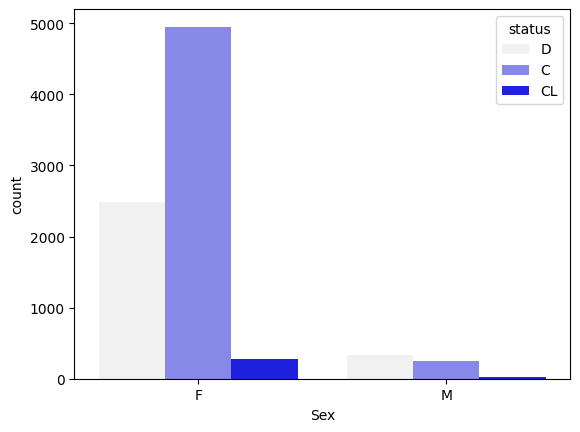

In [11]:
sns.countplot(data=train,x='sex',hue='status',color='blue')
plt.ylabel('count')
plt.xlabel('Sex')
plt.show()

In [12]:
train.head(2)

,n_days,status,drug,age,sex,ascites,hepatomegaly,spiders,edema,bilirubin,cholesterol,albumin,copper,alk_phos,sgot,tryglicerides,platelets,prothrombin,stage
0,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0


In [13]:
train.isnull().sum()

n_days             0
status             0
drug             106
age                0
sex                0
ascites          106
hepatomegaly     106
spiders          106
edema              0
bilirubin          0
cholesterol      134
albumin            0
copper           108
alk_phos         106
sgot             106
tryglicerides    136
platelets         11
prothrombin        2
stage              6
dtype: int64

In [14]:
test.isnull().sum()

id               0
n_days           0
drug             0
age              0
sex              0
ascites          0
hepatomegaly     0
spiders          0
edema            0
bilirubin        0
cholesterol      0
albumin          0
copper           0
alk_phos         0
sgot             0
tryglicerides    0
platelets        0
prothrombin      0
stage            0
dtype: int64

In [15]:
categ_cols = ["drug", "sex", "ascites", "hepatomegaly", "spiders", "edema", "stage"]
numeric_cols = [x for x in train.columns if x not in categ_cols + ['status']]
target_col = 'status'

In [16]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

knn_imputer = KNNImputer()
train[numeric_cols] = knn_imputer.fit_transform(train[numeric_cols])
test[numeric_cols] = knn_imputer.fit_transform(test[numeric_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')
train[categ_cols] = categorical_imputer.fit_transform(train[categ_cols])
test[categ_cols] = categorical_imputer.fit_transform(test[categ_cols])


In [17]:
def date_feat(df):
    
    df['n_days']= pd.to_datetime(df['n_days'])
    df['day_of_week'] = df['n_days'].dt.day_name()
    df['month']= df['n_days'].dt.month
    df['year']= df['n_days'].dt.year
    df['n_days']= df['n_days'].astype('int64')
    
    return df

In [18]:
train = date_feat(train)
test = date_feat(test)

In [19]:
train_df=train.copy()
test_df = test.copy()

In [20]:
print('X_train shape: {}'.format(train_df.shape))
print('X_test shape: {}'.format(test_df.shape))

X_train shape: (8323, 22)
X_test shape: (5271, 22)


In [21]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore').fit(train_df[categ_cols])
encoder_cols = list(encoder.get_feature_names_out(categ_cols))

In [22]:
train_df[encoder_cols] = encoder.transform(train_df[categ_cols]) 
test_df[encoder_cols] = encoder.transform(test_df[categ_cols]) 

In [23]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()    
train_df[target_col] = label_encoder.fit_transform(train_df[target_col])

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_df[numeric_cols])
train_df[numeric_cols] = scaler.fit_transform( train_df[numeric_cols])
test_df[numeric_cols] = scaler.fit_transform( test_df[numeric_cols])

In [25]:
X= train_df[numeric_cols+encoder_cols]
X_test = test_df[numeric_cols+encoder_cols]
y = train_df[target_col]

# Baseline Model

In [26]:
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [27]:
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X,y)
pred = lgb_model.predict_proba(X_test)
print( 'CV score of XGB is',abs(cross_val_score(lgb_model, X,y,cv = 4, scoring='neg_log_loss').mean()))

CV score of XGB is 0.46202087561011895


In [28]:
PATIENCE = 10

xgbr_params ={
'objective': 'multi_logloss', 
 
'max_depth': 9, 'min_child_weight': 8,
'learning_rate': 0.0337716365315986,
'n_estimators': 733,
'subsample': 0.6927955384688348,
'colsample_bytree': 0.1234702658812108, 
'reg_alpha': 0.18561628377665318, 
'reg_lambda': 0.5565488299127089, 
'random_state': 42
}

In [29]:
def ml_model(model, X_train, y_train):
    
    model.fit(X=X_train, y=y_train,
          eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = PATIENCE,
            verbose = 50 )
    
    preds = model.predict_proba(X_test)

In [30]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_repeats=5,n_splits=7, random_state=42)

for train_index,test_index in rkf.split(X,y):
    X_train, X_valid = X.iloc[train_index],X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index],y.iloc[test_index]
    
    XGB = XGBClassifier(**xgbr_params)
    ml_model(XGB, X_train, y_train)

[0]	validation_0-mlogloss:1.07761


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.62903
[100]	validation_0-mlogloss:0.51708
[150]	validation_0-mlogloss:0.47903
[200]	validation_0-mlogloss:0.46129
[250]	validation_0-mlogloss:0.45058
[300]	validation_0-mlogloss:0.44428
[350]	validation_0-mlogloss:0.44008
[359]	validation_0-mlogloss:0.44024
[0]	validation_0-mlogloss:1.07617


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.60136
[100]	validation_0-mlogloss:0.48360
[150]	validation_0-mlogloss:0.44234
[200]	validation_0-mlogloss:0.42276
[250]	validation_0-mlogloss:0.41190
[300]	validation_0-mlogloss:0.40545
[350]	validation_0-mlogloss:0.40250
[400]	validation_0-mlogloss:0.40086
[434]	validation_0-mlogloss:0.39964
[0]	validation_0-mlogloss:1.07709


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.62214
[100]	validation_0-mlogloss:0.51269
[150]	validation_0-mlogloss:0.47574
[200]	validation_0-mlogloss:0.45848
[250]	validation_0-mlogloss:0.44883
[300]	validation_0-mlogloss:0.44294
[350]	validation_0-mlogloss:0.43878
[390]	validation_0-mlogloss:0.43705
[0]	validation_0-mlogloss:1.07714


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.61985
[100]	validation_0-mlogloss:0.50753
[150]	validation_0-mlogloss:0.46804
[200]	validation_0-mlogloss:0.44913
[250]	validation_0-mlogloss:0.43785
[300]	validation_0-mlogloss:0.43052
[350]	validation_0-mlogloss:0.42506
[400]	validation_0-mlogloss:0.42246
[450]	validation_0-mlogloss:0.42067
[500]	validation_0-mlogloss:0.41951
[518]	validation_0-mlogloss:0.41958
[0]	validation_0-mlogloss:1.07695


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.61837
[100]	validation_0-mlogloss:0.50763
[150]	validation_0-mlogloss:0.47070
[200]	validation_0-mlogloss:0.45341
[250]	validation_0-mlogloss:0.44385
[300]	validation_0-mlogloss:0.43803
[350]	validation_0-mlogloss:0.43514
[358]	validation_0-mlogloss:0.43505
[0]	validation_0-mlogloss:1.07702


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.60835
[100]	validation_0-mlogloss:0.49536
[150]	validation_0-mlogloss:0.45684
[200]	validation_0-mlogloss:0.43706
[250]	validation_0-mlogloss:0.42418
[300]	validation_0-mlogloss:0.41666
[350]	validation_0-mlogloss:0.41230
[400]	validation_0-mlogloss:0.40954
[450]	validation_0-mlogloss:0.40830
[500]	validation_0-mlogloss:0.40736
[516]	validation_0-mlogloss:0.40719
[0]	validation_0-mlogloss:1.07659


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.60796
[100]	validation_0-mlogloss:0.48957
[150]	validation_0-mlogloss:0.44696
[200]	validation_0-mlogloss:0.42474
[250]	validation_0-mlogloss:0.41273
[300]	validation_0-mlogloss:0.40607
[350]	validation_0-mlogloss:0.40230
[400]	validation_0-mlogloss:0.40006
[450]	validation_0-mlogloss:0.39881
[500]	validation_0-mlogloss:0.39744
[501]	validation_0-mlogloss:0.39753
[0]	validation_0-mlogloss:1.07691


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.61040
[100]	validation_0-mlogloss:0.49359
[150]	validation_0-mlogloss:0.45058
[200]	validation_0-mlogloss:0.43068
[250]	validation_0-mlogloss:0.41917
[300]	validation_0-mlogloss:0.41271
[350]	validation_0-mlogloss:0.40857
[400]	validation_0-mlogloss:0.40669
[450]	validation_0-mlogloss:0.40554
[452]	validation_0-mlogloss:0.40535
[0]	validation_0-mlogloss:1.07768


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.62148
[100]	validation_0-mlogloss:0.50949
[150]	validation_0-mlogloss:0.47066
[200]	validation_0-mlogloss:0.45283
[250]	validation_0-mlogloss:0.44224
[300]	validation_0-mlogloss:0.43685
[350]	validation_0-mlogloss:0.43363
[400]	validation_0-mlogloss:0.43153
[416]	validation_0-mlogloss:0.43156
[0]	validation_0-mlogloss:1.07683


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.61820
[100]	validation_0-mlogloss:0.50885
[150]	validation_0-mlogloss:0.47177
[200]	validation_0-mlogloss:0.45671
[250]	validation_0-mlogloss:0.44804
[300]	validation_0-mlogloss:0.44374
[350]	validation_0-mlogloss:0.44198
[387]	validation_0-mlogloss:0.44128
[0]	validation_0-mlogloss:1.07684


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.61053
[100]	validation_0-mlogloss:0.49335
[150]	validation_0-mlogloss:0.45020
[200]	validation_0-mlogloss:0.42629
[250]	validation_0-mlogloss:0.41259
[300]	validation_0-mlogloss:0.40372
[350]	validation_0-mlogloss:0.39802
[400]	validation_0-mlogloss:0.39479
[450]	validation_0-mlogloss:0.39213
[500]	validation_0-mlogloss:0.38947
[550]	validation_0-mlogloss:0.38797
[567]	validation_0-mlogloss:0.38795
[0]	validation_0-mlogloss:1.07676


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.61684
[100]	validation_0-mlogloss:0.50888
[150]	validation_0-mlogloss:0.47340
[200]	validation_0-mlogloss:0.45667
[250]	validation_0-mlogloss:0.44894
[300]	validation_0-mlogloss:0.44347
[350]	validation_0-mlogloss:0.44079
[400]	validation_0-mlogloss:0.43910
[431]	validation_0-mlogloss:0.43898
[0]	validation_0-mlogloss:1.07678


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.61649
[100]	validation_0-mlogloss:0.50048
[150]	validation_0-mlogloss:0.45990
[200]	validation_0-mlogloss:0.43955
[250]	validation_0-mlogloss:0.42705
[300]	validation_0-mlogloss:0.42059
[350]	validation_0-mlogloss:0.41778
[400]	validation_0-mlogloss:0.41587
[450]	validation_0-mlogloss:0.41361
[478]	validation_0-mlogloss:0.41311
[0]	validation_0-mlogloss:1.07665


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.61209
[100]	validation_0-mlogloss:0.50012
[150]	validation_0-mlogloss:0.46224
[200]	validation_0-mlogloss:0.44494
[250]	validation_0-mlogloss:0.43315
[300]	validation_0-mlogloss:0.42605
[350]	validation_0-mlogloss:0.42223
[400]	validation_0-mlogloss:0.41945
[450]	validation_0-mlogloss:0.41799
[499]	validation_0-mlogloss:0.41694
[0]	validation_0-mlogloss:1.07691


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.61421
[100]	validation_0-mlogloss:0.49433
[150]	validation_0-mlogloss:0.45142
[200]	validation_0-mlogloss:0.42783
[250]	validation_0-mlogloss:0.41533
[300]	validation_0-mlogloss:0.40756
[350]	validation_0-mlogloss:0.40276
[400]	validation_0-mlogloss:0.39990
[450]	validation_0-mlogloss:0.39763
[472]	validation_0-mlogloss:0.39730
[0]	validation_0-mlogloss:1.07702


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.61581
[100]	validation_0-mlogloss:0.50093
[150]	validation_0-mlogloss:0.46081
[200]	validation_0-mlogloss:0.44000
[250]	validation_0-mlogloss:0.42972
[300]	validation_0-mlogloss:0.42303
[350]	validation_0-mlogloss:0.41965
[400]	validation_0-mlogloss:0.41795
[436]	validation_0-mlogloss:0.41718
[0]	validation_0-mlogloss:1.07750


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.63476
[100]	validation_0-mlogloss:0.53121
[150]	validation_0-mlogloss:0.49546
[200]	validation_0-mlogloss:0.47794
[250]	validation_0-mlogloss:0.46843
[300]	validation_0-mlogloss:0.46185
[350]	validation_0-mlogloss:0.45850
[400]	validation_0-mlogloss:0.45722
[450]	validation_0-mlogloss:0.45574
[456]	validation_0-mlogloss:0.45588
[0]	validation_0-mlogloss:1.07653


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.60773
[100]	validation_0-mlogloss:0.48575
[150]	validation_0-mlogloss:0.44289
[200]	validation_0-mlogloss:0.42193
[250]	validation_0-mlogloss:0.40899
[300]	validation_0-mlogloss:0.40276
[350]	validation_0-mlogloss:0.39924
[387]	validation_0-mlogloss:0.39720
[0]	validation_0-mlogloss:1.07734


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.62606
[100]	validation_0-mlogloss:0.51930
[150]	validation_0-mlogloss:0.48632
[200]	validation_0-mlogloss:0.47036
[250]	validation_0-mlogloss:0.46018
[300]	validation_0-mlogloss:0.45625
[328]	validation_0-mlogloss:0.45507
[0]	validation_0-mlogloss:1.07659


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.60462
[100]	validation_0-mlogloss:0.48987
[150]	validation_0-mlogloss:0.45041
[200]	validation_0-mlogloss:0.43159
[250]	validation_0-mlogloss:0.41865
[300]	validation_0-mlogloss:0.41120
[350]	validation_0-mlogloss:0.40664
[400]	validation_0-mlogloss:0.40316
[450]	validation_0-mlogloss:0.40151
[500]	validation_0-mlogloss:0.39913
[514]	validation_0-mlogloss:0.39912
[0]	validation_0-mlogloss:1.07634


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.60403
[100]	validation_0-mlogloss:0.49003
[150]	validation_0-mlogloss:0.45185
[200]	validation_0-mlogloss:0.43652
[250]	validation_0-mlogloss:0.42960
[300]	validation_0-mlogloss:0.42613
[350]	validation_0-mlogloss:0.42413
[357]	validation_0-mlogloss:0.42411
[0]	validation_0-mlogloss:1.07660


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.60841
[100]	validation_0-mlogloss:0.49667
[150]	validation_0-mlogloss:0.45897
[200]	validation_0-mlogloss:0.44124
[250]	validation_0-mlogloss:0.43307
[300]	validation_0-mlogloss:0.42858
[350]	validation_0-mlogloss:0.42665
[357]	validation_0-mlogloss:0.42634
[0]	validation_0-mlogloss:1.07757


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.62632
[100]	validation_0-mlogloss:0.51527
[150]	validation_0-mlogloss:0.47798
[200]	validation_0-mlogloss:0.46095
[250]	validation_0-mlogloss:0.45010
[300]	validation_0-mlogloss:0.44498
[350]	validation_0-mlogloss:0.44243
[400]	validation_0-mlogloss:0.43960
[419]	validation_0-mlogloss:0.43951
[0]	validation_0-mlogloss:1.07629


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.60071
[100]	validation_0-mlogloss:0.48476
[150]	validation_0-mlogloss:0.44472
[200]	validation_0-mlogloss:0.42508
[250]	validation_0-mlogloss:0.41349
[300]	validation_0-mlogloss:0.40728
[350]	validation_0-mlogloss:0.40434
[387]	validation_0-mlogloss:0.40404
[0]	validation_0-mlogloss:1.07667


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.61594
[100]	validation_0-mlogloss:0.49733
[150]	validation_0-mlogloss:0.45302
[200]	validation_0-mlogloss:0.43018
[250]	validation_0-mlogloss:0.41625
[300]	validation_0-mlogloss:0.40770
[350]	validation_0-mlogloss:0.40198
[400]	validation_0-mlogloss:0.39973
[450]	validation_0-mlogloss:0.39642
[500]	validation_0-mlogloss:0.39380
[517]	validation_0-mlogloss:0.39358
[0]	validation_0-mlogloss:1.07748


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.62540
[100]	validation_0-mlogloss:0.51449
[150]	validation_0-mlogloss:0.47512
[200]	validation_0-mlogloss:0.45569
[250]	validation_0-mlogloss:0.44324
[300]	validation_0-mlogloss:0.43570
[350]	validation_0-mlogloss:0.43062
[400]	validation_0-mlogloss:0.42782
[450]	validation_0-mlogloss:0.42566
[499]	validation_0-mlogloss:0.42471
[0]	validation_0-mlogloss:1.07652


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.60424
[100]	validation_0-mlogloss:0.48973
[150]	validation_0-mlogloss:0.44970
[200]	validation_0-mlogloss:0.43156
[250]	validation_0-mlogloss:0.42046
[300]	validation_0-mlogloss:0.41391
[350]	validation_0-mlogloss:0.40963
[400]	validation_0-mlogloss:0.40778
[446]	validation_0-mlogloss:0.40707
[0]	validation_0-mlogloss:1.07703


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.62476
[100]	validation_0-mlogloss:0.51764
[150]	validation_0-mlogloss:0.48379
[200]	validation_0-mlogloss:0.47027
[250]	validation_0-mlogloss:0.46396
[300]	validation_0-mlogloss:0.46003
[329]	validation_0-mlogloss:0.45861
[0]	validation_0-mlogloss:1.07597


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.60505
[100]	validation_0-mlogloss:0.49016
[150]	validation_0-mlogloss:0.45295
[200]	validation_0-mlogloss:0.43680
[250]	validation_0-mlogloss:0.42903
[300]	validation_0-mlogloss:0.42513
[330]	validation_0-mlogloss:0.42386
[0]	validation_0-mlogloss:1.07594


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.60365
[100]	validation_0-mlogloss:0.48568
[150]	validation_0-mlogloss:0.44566
[200]	validation_0-mlogloss:0.42544
[250]	validation_0-mlogloss:0.41363
[300]	validation_0-mlogloss:0.40764
[350]	validation_0-mlogloss:0.40343
[400]	validation_0-mlogloss:0.39999
[450]	validation_0-mlogloss:0.39784
[500]	validation_0-mlogloss:0.39593
[518]	validation_0-mlogloss:0.39582
[0]	validation_0-mlogloss:1.07681


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.60646
[100]	validation_0-mlogloss:0.48770
[150]	validation_0-mlogloss:0.44706
[200]	validation_0-mlogloss:0.42518
[250]	validation_0-mlogloss:0.41391
[300]	validation_0-mlogloss:0.40676
[350]	validation_0-mlogloss:0.40278
[400]	validation_0-mlogloss:0.40028
[450]	validation_0-mlogloss:0.39803
[500]	validation_0-mlogloss:0.39553
[513]	validation_0-mlogloss:0.39559
[0]	validation_0-mlogloss:1.07707


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.61799
[100]	validation_0-mlogloss:0.50664
[150]	validation_0-mlogloss:0.46766
[200]	validation_0-mlogloss:0.44976
[250]	validation_0-mlogloss:0.43814
[300]	validation_0-mlogloss:0.43099
[350]	validation_0-mlogloss:0.42674
[352]	validation_0-mlogloss:0.42669
[0]	validation_0-mlogloss:1.07703


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.62245
[100]	validation_0-mlogloss:0.51267
[150]	validation_0-mlogloss:0.47318
[200]	validation_0-mlogloss:0.45254
[250]	validation_0-mlogloss:0.44279
[300]	validation_0-mlogloss:0.43621
[350]	validation_0-mlogloss:0.43155
[400]	validation_0-mlogloss:0.42927
[450]	validation_0-mlogloss:0.42770
[455]	validation_0-mlogloss:0.42774
[0]	validation_0-mlogloss:1.07807


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.62772
[100]	validation_0-mlogloss:0.51914
[150]	validation_0-mlogloss:0.48053
[200]	validation_0-mlogloss:0.45965
[250]	validation_0-mlogloss:0.44778
[300]	validation_0-mlogloss:0.44063
[350]	validation_0-mlogloss:0.43554
[400]	validation_0-mlogloss:0.43331
[450]	validation_0-mlogloss:0.43146
[478]	validation_0-mlogloss:0.43081
[0]	validation_0-mlogloss:1.07711


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[50]	validation_0-mlogloss:0.61887
[100]	validation_0-mlogloss:0.50548
[150]	validation_0-mlogloss:0.46561
[200]	validation_0-mlogloss:0.44680
[250]	validation_0-mlogloss:0.43599
[300]	validation_0-mlogloss:0.42996
[350]	validation_0-mlogloss:0.42715
[400]	validation_0-mlogloss:0.42497
[420]	validation_0-mlogloss:0.42463


In [31]:
from sklearn.ensemble import VotingClassifier

Ensemble = VotingClassifier(estimators = [('lgb', lgb_model), ('XGB', XGB)], 
                            voting='soft',
                            weights = [1, 0.8]  
                           )

Ensemble.fit(X, y)

VotingClassifier(estimators=[('lgb', LGBMClassifier(random_state=42)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.1234702658812108,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importa...
                                            interaction_constraints=None,
                                            learning_rate=0.0337716365315986,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=9,
                                            max_leaves=None, min_child_weight=8,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=733, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft', weights=[1, 0.8])

In [32]:
preds = Ensemble.predict_proba(X_test)
preds = pd.DataFrame(preds, columns = ['C', 'CL', 'D'])

In [33]:
sample_sub['Status_C'] = preds['C']
sample_sub['Status_CL'] = preds['CL']
sample_sub['Status_D'] = preds['D']
sample_sub.to_csv('submission.csv', index = False)

In [34]:
sample_sub

,id,Status_C,Status_CL,Status_D
0,7905,0.443068,0.021039,0.535893
1,7906,0.479450,0.232017,0.288533
2,7907,0.033044,0.009272,0.957685
3,7908,0.966016,0.002111,0.031874
4,7909,0.880197,0.037847,0.081955
...,...,...,...,...
5266,13171,0.885164,0.081250,0.033586
5267,13172,0.974680,0.004895,0.020425
5268,13173,0.912855,0.008375,0.078770
5269,13174,0.980829,0.002864,0.016308
